In [13]:
import logging, sys
logging.disable(sys.maxsize)

# Let's do a selection based on a pure monte-carlo over all time where observing might occure. 
# Let's see if this converges quickly enough.
import astropy.time
from pycbc.distributions import Uniform, UniformSky, SinAngle, UniformAngle
from pycbc.detector import Detector
from urllib.error import HTTPError
from gworacle import query, range as qrange, psd
from astropy.utils.data import download_file
from pycbc.waveform import get_fd_waveform
from pycbc.filter import sigma
from pycbc.cosmology import redshift
import numpy
import pickle
import tqdm

o3_psds = pickle.load(open('./psds/psds_ave.pkl', 'rb'))

combos = [
            ["H1", "L1", "V1"],
            ["H1", "L1"],
            ["H1", "V1"],
            ["L1", "V1"], 
            ["H1"], ["L1"], ["V1"],
         ]
times = [
         [0, 48.6, 0, 0, 27.6, 17.0, 0],
         [15.2, 103.3, 1.7, 2.2, 37.8, 33.0, 1.7],
         [152.0, 49.5, 31.7, 38.9, 10.3, 9.9, 25.0],
        ]

hps = {}
masses = numpy.geomspace(1, 500, 80)
srcmasses = numpy.geomspace(1, 500, 80)

for m in masses:
    hps[m], _ = get_fd_waveform(approximant="IMRPhenomD", mass1=m, mass2=m, f_lower=20, delta_f=1.0/512)

vt_det = 0
vt_src = 0

size = int(1e3)

mdetmat = numpy.resize(masses, size * len(masses)).reshape(size, len(masses))

sky = UniformSky().rvs(size=size)
inc = SinAngle(inclination=None).rvs(size=size)['inclination']
pol = UniformAngle(polarization=None).rvs(size=size)['polarization']

relsnr = {}
for ifo in ['H1', 'L1', 'V1']:
    det = Detector(ifo)
    fp, fc = det.antenna_pattern(sky['ra'], sky['dec'], pol, 1000000000)
    ic = numpy.cos(inc)
    ip = 0.5 * (1.0 + ic * ic)
    relsnr[ifo] = ((ip * fp) ** 2.0 + (ic * fc) ** 2.0) ** 0.5 # Relative SNR


def get_vt(psds, ifos, dt):
    vt_src_part = numpy.zeros(len(srcmasses))
    vt_det_part = numpy.zeros(len(masses))
    sig = {}
    
    if psds is None:
        return vt_src_part, vt_det_part
    
    for k in ifos:
        sig[k] = numpy.array([sigma(hps[m], psds[k], low_frequency_cutoff=20, high_frequency_cutoff=1000) for m in masses])
    
    nthresh = 10.0
    
   
    nsnrsq = 0
    for ifo in ifos: 
        nsnrsq += (numpy.outer(relsnr[ifo], sig[ifo])) ** 2.0 # SNR at fiducial distance
            # Fiducial is 1Mpc, that way it can also be intereprted as the distance that gives you SNR 1. 

    if len(ifos) > 0:
        nsnr = nsnrsq ** 0.5
        dsamp = (nsnr / nthresh) # Distance at SNR threshold for sample
        z = redshift(dsamp) # Redshift limit at each sample
        msrc = mdetmat / (1 + z)  # Source frame mass each sample corresponds to 
        
        vt_samp = 4/3 * numpy.pi * dsamp**3.0 / size * dt # The per sample VT
        vt_det_part += vt_samp.sum(axis=0) # detector-frame vt

        # Simple linear interpolation

        for i in range(size):
            vt_src_part += numpy.interp(srcmasses, msrc[i, :], vt_samp[i, :])

    return vt_src_part, vt_det_part

vtps = []
for psds, t in zip(o3_psds, times):
    for dt, ifos in zip(t, combos):
        if dt == 0:
            continue
        vtp = get_vt(psds, ifos, dt)
        print(ifos, dt)
        vtps.append(vtp)

for vtp in vtps:
    vt_src += vtp[0]
    vt_det += vtp[1]
    
    print(vt_det[4]  / 365.25 / 1000, vt_src[4]  / 365.25 / 1000)

['H1', 'L1'] 48.6
['H1'] 27.6
['L1'] 17.0
['H1', 'L1', 'V1'] 15.2
['H1', 'L1'] 103.3
['H1', 'V1'] 1.7
['L1', 'V1'] 2.2
['H1'] 37.8
['L1'] 33.0
['V1'] 1.7
['H1', 'L1', 'V1'] 152.0
['H1', 'L1'] 49.5
['H1', 'V1'] 31.7
['L1', 'V1'] 38.9
['H1'] 10.3
['L1'] 9.9
['V1'] 25.0
225.08749211161637 238.34214962016503
283.5044334603313 299.4480993767084
305.01968536576334 321.801634491972
422.2904837228932 447.1449759942661
1172.0065877278587 1248.3147131277162
1175.9722226373174 1252.4607548452673
1183.936645387762 1260.8560723418727
1260.5245571847752 1340.9051954422418
1368.3296946157604 1454.5133738850338
1368.4956974943998 1454.6820856136655
5499.097261122434 6016.053454320601
6741.818933858411 7387.814018025039
6990.260103963309 7653.00521249467
7518.435052503231 8225.2343553052
7585.045265026523 8296.283280270918
7703.2858408444135 8424.313825237985
7715.739932738611 8437.118427306848


In [14]:
import h5py
with h5py.File('./vt_chirp_10_O13.hdf', 'w') as f:
    f['srcmasses'] = srcmasses
    f['masses'] = masses
    f['vt_src'] = vt_src / 365.25 / 1e9
    f['vt_det'] = vt_det / 365.25 / 1e9

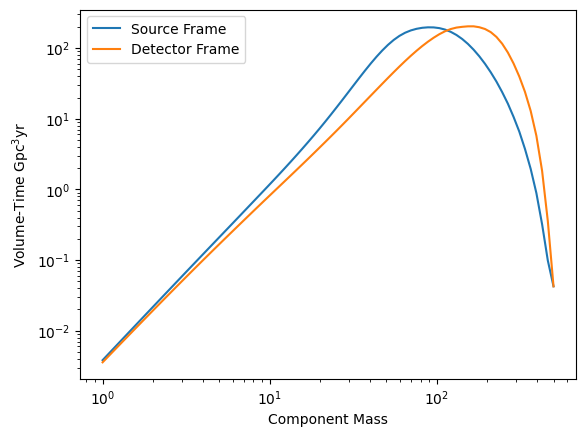

In [16]:
from matplotlib import pyplot as plt

plt.figure()
plt.plot(srcmasses, vt_src / 365.25 / 1e9, label="Source Frame")
plt.plot(masses, vt_det / 365.25 / 1e9, label="Detector Frame")
plt.xlabel('Component Mass')
plt.ylabel("Volume-Time Gpc$^3$yr")
plt.yscale('log')
plt.xscale('log')
plt.legend()